In [1]:
from pathlib import Path

import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
import torch
import torch.nn.functional as F
from openslide import OpenSlide
from IPython.display import display
from tqdm import tqdm
from torchvision import transforms
from torchvision.transforms.v2 import JPEG

from histomining.models.foundation_models import load_model
from histomining.models.linear_probing import LinearProbingFromEmbeddings
from histomining.data.torch_datasets import TileDataset
from histomining.utils import get_device 

In [2]:
device = get_device(gpu_id=0)

Using cuda:0


In [3]:
wsi_dir = Path("/mnt/nas6/data/CPTAC")
# wsi_dir = Path("/mnt/nas7/data/TCGA_Lung_svs")
tiles_root_dir = "/mnt/nas7/data/Personal/Valentin/histopath/tiles_14jan25"

In [4]:
def get_wsi_path(wsi_id, wsi_dir):
    wsi_paths = [f for f in wsi_dir.rglob(wsi_id + "*.svs")]
    if len(wsi_paths) > 1:
        raise ValueError(f"Multiple WSI files found for {wsi_id}: {wsi_paths}")
    return wsi_paths[0]

def get_tiles_dir(wsi_id, tiles_root_dir):
    tiles_dir_match = list(Path(tiles_root_dir).glob(f"./*/{wsi_id}"))
    if len(list(tiles_dir_match)) != 1:
        raise ValueError(f"Multiple tile directories found for {wsi_id}: {list(tiles_dir_match)}")
    tiles_dir = tiles_dir_match[0] / "tiles"
    return tiles_dir

In [5]:
model, preprocess, embedding_dim, autocast_dtype = load_model("UNI2",device )

Applying torch scripting...


In [6]:
linear_probing = LinearProbingFromEmbeddings.load_from_checkpoint("/home/valentin/workspaces/histomining/models/linear_probing_from_embeddings/linear_probing_weights_uni2_mag_key_5_with_resizing.ckpt", map_location=device)

In [7]:
wsi_id = "C3L-00009-21"
# wsi_id = "C3L-00080-21"
# wsi_id = "TCGA-49-4506-01Z-00-DX2"

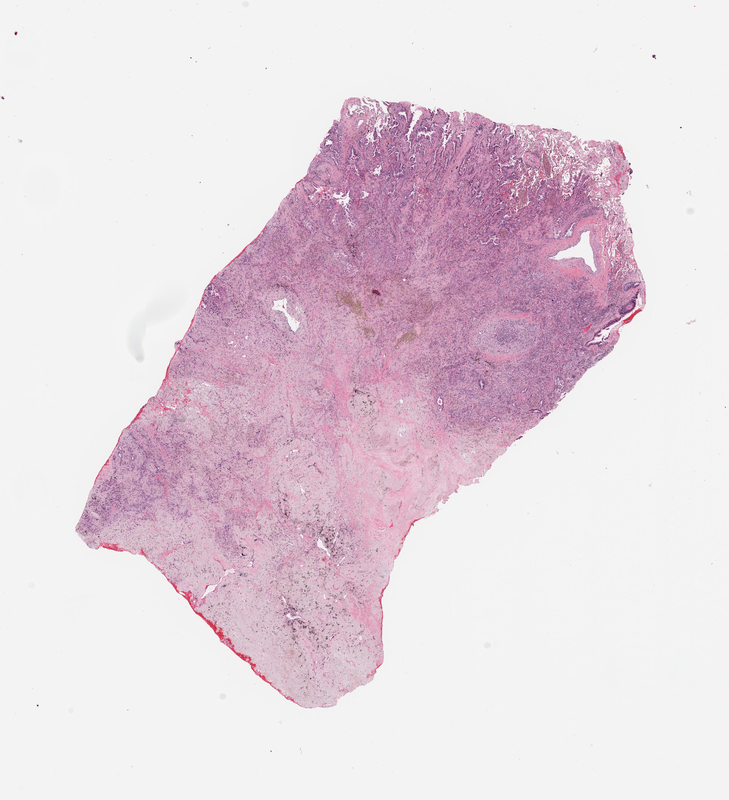

In [8]:
wsi_path = get_wsi_path(wsi_id, wsi_dir)
wsi = OpenSlide(wsi_path)
thumbnail = wsi.get_thumbnail((800,800))
display(thumbnail)

In [9]:
tile_paths = list(get_tiles_dir(wsi_id, tiles_root_dir).glob("*.png"))
tile_ids = [tile_path.stem for tile_path in tile_paths]

In [10]:
print(f"Number of tiles: {len(tile_ids)}")

Number of tiles: 642


In [11]:
transform = transforms.Compose(
            [
                transforms.CenterCrop(224),
                JPEG(quality=(85,95)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=torch.Tensor([0.485, 0.456, 0.406]),
                    std=torch.Tensor([0.229, 0.224, 0.225]),
                ),
            ]
        )

In [12]:
dataset = TileDataset(tile_paths=tile_paths, preprocess=transform)

In [13]:
preprocess

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [14]:
dataloader = DataLoader(
    dataset,
    batch_size=256,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

In [15]:
embeddings = []
preds = []
logits = []
with torch.inference_mode():
    for batch in tqdm(dataloader, desc="Computing embeddings"):
        batch_embeddings = model(batch.to(device))
        embeddings.append(batch_embeddings.cpu().numpy())
        batch_logits = linear_probing(batch_embeddings)
        logits.append(batch_logits.cpu().numpy())
        preds.append(F.softmax(batch_logits, dim=1).cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0)
preds = np.concatenate(preds, axis=0)
logits = np.concatenate(logits, axis=0)

Computing embeddings: 100%|██████████| 3/3 [00:20<00:00,  6.68s/it]


In [16]:
# Save embeddings, predictions, logits, and tile_ids
np.savez_compressed(
    f"/home/valentin/workspaces/histomining/data/processed/embeddings_test/{wsi_id}_embeddings_10x_jpgartifact.npz",
    embeddings=embeddings,
    preds=preds,
    logits=logits,
    tile_ids=np.array(tile_ids, dtype=object),  # Convert to numpy array for storage
)

In [ ]:
preds[:,1].max()

In [ ]:
def plot_attention_map(attention_map, thumbnail):
    # Normalize the attention map between 0 and 1
    attention_norm = (attention_map - attention_map.min()) / (
        attention_map.max() - attention_map.min()
    )

    # Plotting
    plt.figure(figsize=(10, 10))

    # Show WSI thumbnail
    plt.imshow(thumbnail, cmap="gray" if thumbnail.ndim == 2 else None)

    # Overlay attention heatmap with transparency
    plt.imshow(attention_norm, cmap="jet", alpha=0.5)  # alpha adjusts transparency

    plt.axis("off")
    plt.title("WSI Thumbnail with Attention Overlay")
    plt.tight_layout()
    plt.show()

In [ ]:

def compute_attention_map(
    attention_scores: np.array,
    tile_ids: list,
    tile_size: int = 224,
    tile_mpp: float = 1.0,
    wsi_path: str = None,
    output_mpp: float = 2.0,
    return_thumbnail: bool = True,
) -> np.array:
    attention_scores = np.squeeze(attention_scores)
    wsi = OpenSlide(wsi_path)
    mpp_x, mpp_y = (
        wsi.properties.get("openslide.mpp-x"),
        wsi.properties.get("openslide.mpp-y"),
    )
    if mpp_x is None or mpp_y is None:
        raise ValueError("Microns per pixel not found in WSI properties.")
    if mpp_x != mpp_y:
        raise ValueError("Microns per pixel values are not equal.")

    mpp_x = float(mpp_x)
    resizing_factor = mpp_x / output_mpp
    wsi_width, wsi_height = wsi.level_dimensions[0]
    width = int(wsi_width * resizing_factor)
    height = int(wsi_height * resizing_factor)

    attention_map = np.zeros((height, width), dtype=np.float32)
    resized_tile_size = int(tile_size * resizing_factor * tile_mpp / mpp_x)
    for tile_idx, tile_id in enumerate(tile_ids):
        x, y = get_position_from_tile_id(tile_id)
        resized_x = int(x * resizing_factor)
        resized_y = int(y * resizing_factor)
        attention_map[
            resized_y : resized_y + resized_tile_size,
            resized_x : resized_x + resized_tile_size,
        ] = attention_scores[tile_idx]

    if return_thumbnail:
        thumbnail = wsi.get_thumbnail((width, height))
        return attention_map, thumbnail
    return attention_map


def get_position_from_tile_id(tile_id):
    # tile_id = tile_id.decode("utf-8")
    parts = tile_id.split("__x")[1].split("_y")
    x = int(parts[0])
    y = int(parts[1])
    return x, y

In [ ]:
attention_map, thumbnail = compute_attention_map(preds[:,0], tile_ids, tile_size=224, tile_mpp=1.0, wsi_path=wsi_path, output_mpp=5.0)

In [ ]:
attention_map_thresholded = np.where(attention_map > 0.5, attention_map, 0)

In [ ]:
attention_map_thresholded

In [ ]:
attention_map.min()

In [ ]:
plot_attention_map(attention_map, np.array(thumbnail))